## RBIF 110 Cheminformatics
### Sample Virtual Screening Workflow
By Jeff Warrington


In [2]:
import os
#os.rename("pymol-edu-license.lic", "license.lic")


In [2]:
!curl -L -o smina.static https://sourceforge.net/projects/smina/files/smina.static/download


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   585  100   585    0     0   2253      0 --:--:-- --:--:-- --:--:--  2276

100   327  100   327    0     0    673      0 --:--:-- --:--:-- --:--:--   673
100   327  100   327    0     0    673      0 --:--:-- --:--:-- --:--:--     0

100 9622k  100 9622k    0     0  7275k      0  0:00:01  0:00:01 --:--:-- 7275k


In [3]:
!python --version

!mamba --version

Python 3.11.11


2.0.5


In [4]:
import subprocess
import sys
import shutil
import tqdm.notebook as tqdm

# Define function to install packages
def install_package(command, progress, step):
    try:
        subprocess.run(command, shell=True, check=True)
        progress.update(step)
    except subprocess.CalledProcessError as e:
        print(f"Error installing {command}: {e}")

# Initialize progress bar
total_steps = 100
with tqdm.tqdm(total=total_steps) as pbar:
    
    # Ensure conda is available
    if not shutil.which("mamba"):
        print("Mamba is not installed. Please install it first.")
    
    install_package("conda install -c conda-forge libnetcdf -y", pbar, 10)
    
    # Install PyMOL
    install_package("mamba install -c schrodinger pymol-bundle --yes", pbar, 10)
    
    install_package("conda install -c conda-forge gemmi -y", pbar, 10)

    # Install mols2grid
    install_package("mamba install -c conda-forge mols2grid --yes", pbar, 20)

    # Install RDKit
    install_package("mamba install -c conda-forge rdkit --yes", pbar, 20)

    # Install py3Dmol
    install_package("mamba install -c conda-forge py3Dmol --yes", pbar, 30)

print("All packages installed successfully.")



  0%|          | 0/100 [00:00<?, ?it/s]

All packages installed successfully.


In [9]:
#import some cheminformatics packages and data processing packages
import rdkit
from rdkit import Chem

import py3Dmol
import mols2grid

import numpy as np
import pandas as pd

import shutil
import os

# Define paths
license_src = os.path.abspath("license.lic")  # Path to your existing license file
pymol_license_dir = os.path.expanduser("~/.pymol")  # Default PyMOL license directory

# Ensure the directory exists
os.makedirs(pymol_license_dir, exist_ok=True)

# Copy license file to the expected location
shutil.copy(license_src, os.path.join(pymol_license_dir, "pymol.lic"))

os.environ["PYMOL_LICENSE_FILE"] = os.path.join(pymol_license_dir, "pymol.lic")


In [10]:
import os
import gemmi
import pandas as pd

# Directory containing .cif files
cif_dir = "./a6_files"

# List to store extracted data
summary_data = []

# Process each .cif file
for cif_file in os.listdir(cif_dir):
    if cif_file.endswith(".cif"):
        file_path = os.path.join(cif_dir, cif_file)
        
        # Read CIF file using gemmi
        cif_doc = gemmi.cif.read(file_path)  # Read mmCIF file
        block = cif_doc.sole_block()  # Get the first block
        
        # Extract PDB ID (cleaned)
        pdb_id = cif_file.replace(".cif", "").replace("_updated", "")
        
        # Extract resolution safely
        resolution = None
        res_value = block.find_value('_refine.ls_d_res_high')
        if res_value and res_value.replace('.', '', 1).isdigit():  # Check if res_value is not None and numeric
            resolution = float(res_value)

        # Extract ligand information
        ligands = set()
        structure = gemmi.make_structure_from_block(block)  # Convert to gemmi Structure
        
        for model in structure:
            for chain in model:
                for res in chain:
                    if res.subchain:  # Ligands typically have a non-empty subchain
                        ligands.add(res.name)

        # Only add structures that have at least one ligand
        if ligands:
            summary_data.append({
                "PDB_ID": pdb_id,
                "Resolution (Å)": resolution,
                "Ligands": ", ".join(ligands)
            })

# Convert to DataFrame
df = pd.DataFrame(summary_data)

# Sort by resolution (lower = better), ignoring NaN values
df_sorted = df.sort_values(by="Resolution (Å)", ascending=True, na_position='last')

# Display the filtered DataFrame (top 10 results)
print(df_sorted.head(10).to_string(index=False))  # Prints formatted table


PDB_ID  Resolution (Å)                                                                                                           Ligands
  7mzy           1.500      SER, GLY, ALA, PHE, ACT, ILE, HOH, GLN, TRP, TYR, ASN, VAL, CYS, ASP, LYS, ARG, PRO, THR, GLU, HIS, MET, LEU
  4z55           1.550 SER, GLY, ALA, PHE, ILE, 4LO, HOH, GLN, TRP, TYR, ASN, VAL, CYS, ASP, LYS, ARG, GOL, PRO, THR, GLU, HIS, MET, LEU
  9gbe           1.580    SER, GLY, ALA, PHE, ILE, HOH, GLN, TRP, TYR, A1IJ8, ASN, VAL, CYS, ASP, LYS, ARG, PRO, THR, GLU, HIS, MET, LEU
  5a9u           1.600      SER, GLY, ALA, PHE, ILE, HOH, GLN, TRP, TYR, ASN, VAL, CYS, ASP, LYS, ARG, PRO, THR, 5P8, GLU, HIS, MET, LEU
  8arj           1.645      SER, GLY, ALA, NRR, PHE, ILE, HOH, GLN, TRP, TYR, ASN, VAL, CYS, ASP, LYS, ARG, PRO, THR, GLU, HIS, MET, LEU
  4clj           1.660      SER, GLY, ALA, PHE, ILE, HOH, GLN, TRP, TYR, ASN, VAL, CYS, ASP, LYS, ARG, PRO, THR, 5P8, GLU, HIS, MET, LEU
  2yfx           1.700      SER, GLY, ALA

In [11]:
# Define the CIF file path
cif_file = "./a6_files/4z55_updated.cif"

# Read the CIF file
cif_doc = gemmi.cif.read(cif_file)
block = cif_doc.sole_block()

# Extract PDB ID
pdb_id = "4Z55"

# Extract resolution
resolution = None
res_value = block.find_value('_refine.ls_d_res_high')
if res_value and res_value.replace('.', '', 1).isdigit():
    resolution = float(res_value)

# Extract protein and ligand details
structure = gemmi.make_structure_from_block(block)

ligands = set()
chains = set()

for model in structure:
    for chain in model:
        chains.add(chain.name)  # Collect chain names
        for res in chain:
            if res.subchain:  # Ligands typically have a non-empty subchain
                ligands.add(res.name)

# Generate a structured report
report = f"""
# Structural Report: {pdb_id}

## General Information:
- **PDB ID:** {pdb_id}
- **Resolution:** {resolution} Å
- **Number of Chains:** {len(chains)}
- **Chains Present:** {', '.join(sorted(chains))}

## Ligand Information:
- **Bound Ligands:** {', '.join(ligands) if ligands else "None"}

## Summary:
PDB structure {pdb_id} has a resolution of {resolution} Å and contains {len(chains)} chains. 
The structure includes the following bound ligands: {', '.join(ligands) if ligands else "None"}.
This makes it a suitable candidate for further **virtual screening**.

"""

# Save the report to a text file
output_report = "./4z55_report.txt"
with open(output_report, "w") as f:
    f.write(report)

# Print confirmation
print(f"Report generated: {output_report}")


Report generated: ./4z55_report.txt


# Structural Report: 4Z55

## General Information:
- **PDB ID:** 4Z55
- **Resolution:** 1.55 Å
- **Number of Chains:** 1
- **Chains Present:** A

## Ligand Information:
- **Bound Ligands:** LEU, ILE, THR, TYR, PRO, GLN, HIS, PHE, GLY, ARG, 4LO, HOH, VAL, SER, TRP, ALA, ASP, ASN, CYS, MET, GOL, LYS, GLU

## Summary:
PDB structure 4Z55 has a resolution of 1.55 Å and contains 1 chains. 
The structure includes the following bound ligands: LEU, ILE, THR, TYR, PRO, GLN, HIS, PHE, GLY, ARG, 4LO, HOH, VAL, SER, TRP, ALA, ASP, ASN, CYS, MET, GOL, LYS, GLU.
This makes it a suitable candidate for further **virtual screening**.


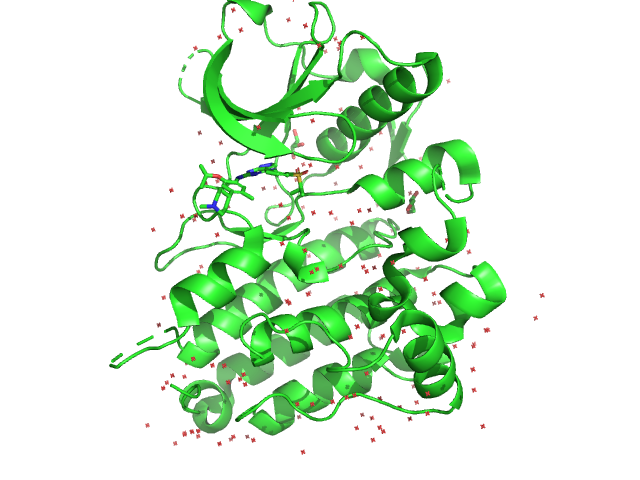

In [12]:

#Test to make sure pymol is working lets download melatonin receptor and display
from pymol import cmd
from IPython.display import Image
cmd.reinitialize()
cmd.fetch("4Z55")
cmd.orient("4Z55")
cmd.rotate("z","270")
cmd.png("4Z55.png") #In order to display in our python notebook we need to make a temp image called image.png
Image(filename = "4Z55.png", unconfined=True)


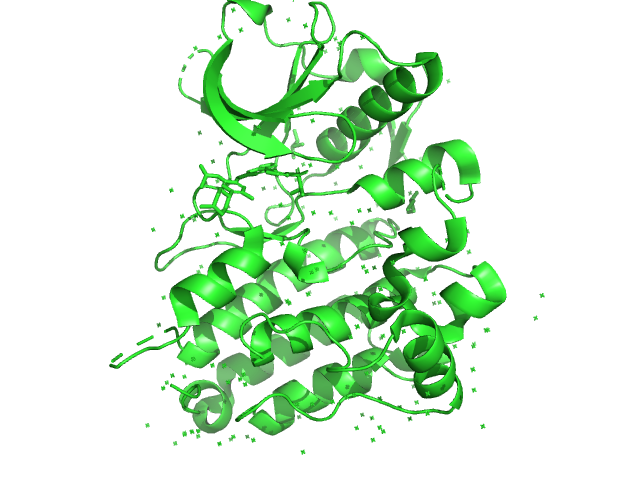

In [13]:
#There are likely multiple chains here, so we need to check that (CBC = Color By Chain)
cmd.util.cbc()
cmd.png("4Z55.png")
Image(filename = "4Z55.png", unconfined=True)

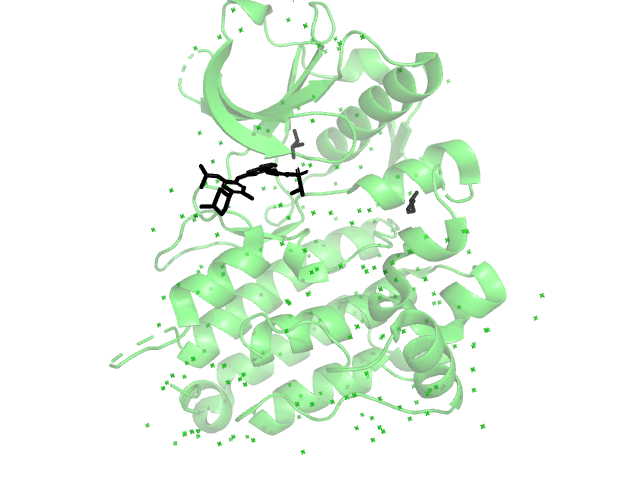

In [14]:
cmd.color("black","organic")
cmd.set("cartoon_transparency",0.5)
cmd.png("4Z55.png")
Image(filename = "4Z55.png", unconfined=True)

#### **Observation:** By coloring the organic structures black, and reducing the cartoon transparency, we can see that there are two replicate chains in the crystal structure, but we will only need one for the docking experiment.

In [15]:
import gemmi

# Load the CIF file
cif_file = "./a6_files/4z55_updated.cif"
cif_doc = gemmi.cif.read(cif_file)
block = cif_doc.sole_block()

# Extract structure
structure = gemmi.make_structure_from_block(block)

# Define ligand interaction distance cutoff (e.g., 5.0Å)
interaction_distance = 5.0

# Define the target ligand ("4LO") from RCSB: https://www.rcsb.org/structure/4z55
ligand_name = "4LO"

# Define the target protein chain (A)
target_chain = "A"

# List of standard amino acids
standard_amino_acids = {
    "ALA", "ARG", "ASN", "ASP", "CYS", "GLN", "GLU", "GLY",
    "HIS", "ILE", "LEU", "LYS", "MET", "PHE", "PRO", "SER",
    "THR", "TRP", "TYR", "VAL"
}

# Step 1: Identify 4LO ligand atoms
ligand_atoms = []
for model in structure:
    for chain in model:
        for res in chain:
            if res.name == ligand_name:  # Look for 4LO
                for atom in res:
                    ligand_atoms.append(atom.pos)  # Store 4LO atom positions

# Step 2: Find only **unique** protein residues near 4LO
binding_residues = set()  # Use a **set** to avoid duplicates

for model in structure:
    for chain in model:
        if chain.name == target_chain:  # Only process Chain A
            for res in chain:
                if res.seqid.num:  # Ensure residue has a valid ID
                    if res.name in standard_amino_acids:  # Ensure it's a protein residue
                        # Check if **any** atom in this residue is within the threshold distance of 4LO
                        for atom in res:
                            if any(atom.pos.dist(lig_atom) <= interaction_distance for lig_atom in ligand_atoms):
                                binding_residues.add((res.name, res.seqid.num, chain.name))  # Store unique residues
                                break  # Avoid duplicates

# Step 3: Print the refined 4LO-binding residues
if binding_residues:
    print(f"✅ {len(binding_residues)} Unique Protein Residues Interacting with 4LO in Chain {target_chain} (≤{interaction_distance}Å):")
    for res in sorted(binding_residues, key=lambda x: x[1])[:50]:  # Print first 50 for readability
        print(f"- **Residue:** {res[0]} (ID: {res[1]}), Chain: {res[2]}")
else:
    print(f"❌ No protein residues found within {interaction_distance}Å of 4LO.")


✅ 25 Unique Protein Residues Interacting with 4LO in Chain A (≤5.0Å):
- **Residue:** LEU (ID: 1122), Chain: A
- **Residue:** GLY (ID: 1123), Chain: A
- **Residue:** HIS (ID: 1124), Chain: A
- **Residue:** GLY (ID: 1125), Chain: A
- **Residue:** ALA (ID: 1126), Chain: A
- **Residue:** VAL (ID: 1130), Chain: A
- **Residue:** GLU (ID: 1132), Chain: A
- **Residue:** ALA (ID: 1148), Chain: A
- **Residue:** LYS (ID: 1150), Chain: A
- **Residue:** VAL (ID: 1180), Chain: A
- **Residue:** LEU (ID: 1196), Chain: A
- **Residue:** GLU (ID: 1197), Chain: A
- **Residue:** LEU (ID: 1198), Chain: A
- **Residue:** MET (ID: 1199), Chain: A
- **Residue:** ALA (ID: 1200), Chain: A
- **Residue:** GLY (ID: 1201), Chain: A
- **Residue:** GLY (ID: 1202), Chain: A
- **Residue:** ASP (ID: 1203), Chain: A
- **Residue:** SER (ID: 1206), Chain: A
- **Residue:** GLU (ID: 1210), Chain: A
- **Residue:** ARG (ID: 1253), Chain: A
- **Residue:** ASN (ID: 1254), Chain: A
- **Residue:** LEU (ID: 1256), Chain: A
- **Residu

In [16]:
#Now we need to split the above into a ligand and a receptor file
cmd.select("4Z55-ligand", "resn 4LO") #Create a selection called 4Z55-ligand from the ligand
cmd.select("4Z55-receptor", "4Z55 and not 4Z55-ligand")  #Select all that is not the ligand, and make that the protein
cmd.save("4Z55-ligand.pdb", "4Z55-ligand")
cmd.save("4Z55-receptor.pdb", "4Z55-receptor")

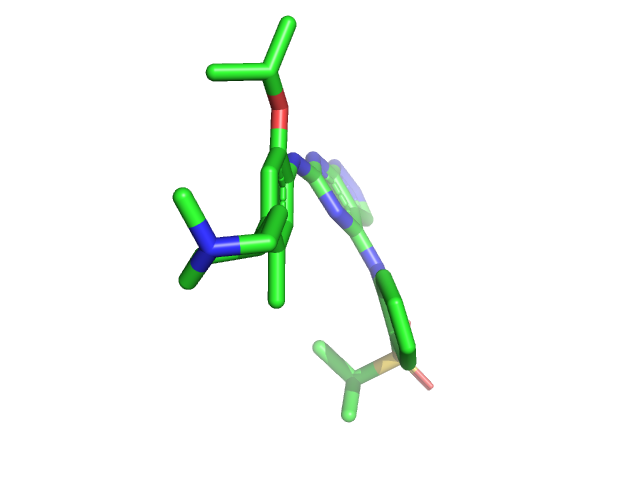

In [17]:
#Now lets look at the individual files -first the ligand
cmd.reinitialize() #Wipe the pymol memory and create an empty workspace
cmd.load("4Z55-ligand.pdb")
cmd.png("ligand.png")
Image(filename = "ligand.png", unconfined=True)

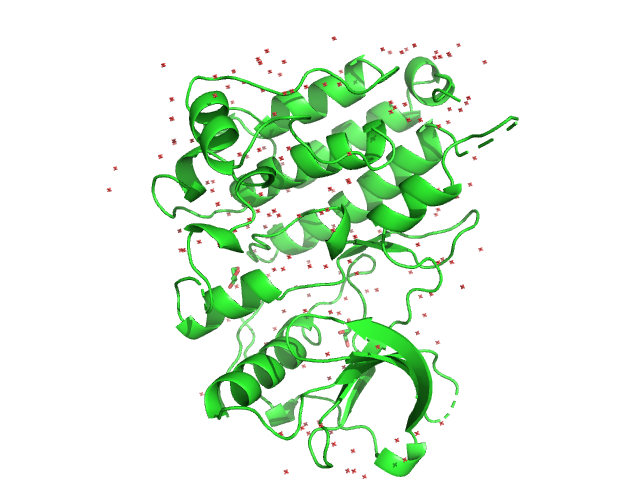

In [18]:
#Now the receptor
cmd.reinitialize() #Wipe the pymol memory and create an empty workspace
cmd.load("4Z55-receptor.pdb")
cmd.orient("4Z55-receptor")
cmd.rotate("z","270")
cmd.png("receptor.png")
Image(filename = "receptor.png", unconfined=True)

In [19]:
#Lets look at the smina program - you can get a list of possible commands and switches by just running the program with no arguments
!wsl ./smina.static



Missing receptor.

Correct usage:

Input:
  -r [ --receptor ] arg         rigid part of the receptor (PDBQT)
  --flex arg                    flexible side chains, if any (PDBQT)
  -l [ --ligand ] arg           ligand(s)
  --flexres arg                 flexible side chains specified by comma 
                                separated list of chain:resid or 
                                chain:resid:icode
  --flexdist_ligand arg         Ligand to use for flexdist
  --flexdist arg                set all side chains within specified distance 
                                to flexdist_ligand to flexible

Search space (required):
  --center_x arg                X coordinate of the center
  --center_y arg                Y coordinate of the center
  --center_z arg                Z coordinate of the center
  --size_x arg                  size in the X dimension (Angstroms)
  --size_y arg                  size in the Y dimension (Angstroms)
  --size_z arg                  size in the Z dimen

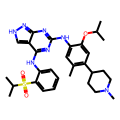

In [20]:
#So now we need to make a new file, that has a "pure" unbiased version of the ligand - so lets create it directly from SMILES
#We can get the ligand information here: https://www.rcsb.org/ligand/4LO
# CC(C)Oc1cc(C2CCN(C)CC2)c(C)cc1Nc3nc(Nc4ccccc4[S](=O)(=O)C(C)C)c5c[nH]nc5n3
from rdkit import Chem
from rdkit.Chem import Draw

size = (120, 120)

lig = Chem.MolFromSmiles("CC(C)Oc1cc(C2CCN(C)CC2)c(C)cc1Nc3nc(Nc4ccccc4[S](=O)(=O)C(C)C)c5c[nH]nc5n3")
img = Draw.MolToImage(lig, size=size)
img



#### This is a 2D structure without 3D coordinates. SMINA needs a 3D structure - we can only get that by minimizing to the nearest energy minima. Thankfully RDKit has a minimizer

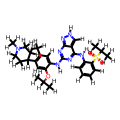

In [21]:
lig = Chem.AddHs(lig, addCoords=True) #We need to add hydrogens to the new ligand
Draw.MolToImage(lig, size=size)

In [22]:
#Now to minimize to a 3D structure using the AllChem Module
import py3Dmol
from rdkit.Chem import AllChem
AllChem.EmbedMolecule(lig)
AllChem.MMFFOptimizeMolecule(lig)


#Display the result using py3Dmol
mblock = Chem.MolToMolBlock(lig)

view = py3Dmol.view(data=mblock, style={"stick": {}, "sphere": {"scale": 0.3}})
view.zoomTo()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [26]:
#Allright now we have the molecule converted to 3D - sae it as a new sdf
file = Chem.SDWriter('newligand_1.sdf') #create the file
file.write(lig) #write the 3d ligand to the file


['4Z55-receptor', '4Z55-ligand', 'newligand_1']


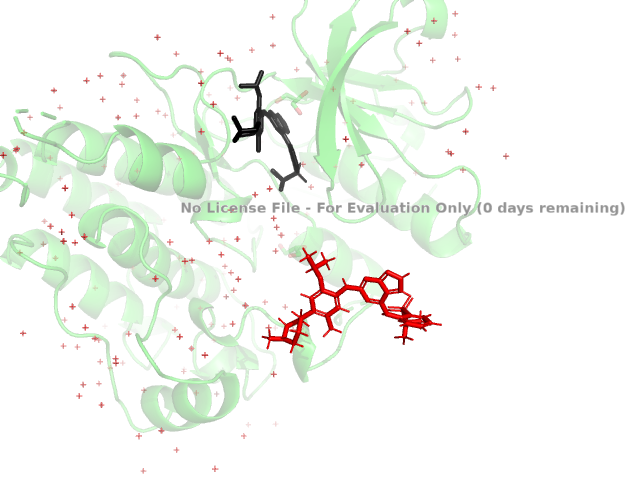

In [27]:
#Lets check the new ligand - so the new ligand should be assigned random coordinates in space. If we load this new one into our previous PDB file, we will see it's somewhere random
cmd.reinitialize() #Wipe the pymol memory and create an empty workspace
cmd.load("4Z55-receptor.pdb")
cmd.load("4Z55-ligand.pdb")
cmd.color("black","4Z55-ligand")
cmd.load("newligand_1.sdf")

print(cmd.get_object_list())


cmd.color("red","newligand")
cmd.set("cartoon_transparency",0.6)
cmd.select("ligands", "organic")
cmd.zoom("ligands")
#cmd.rotate("z","270")
cmd.png("receptor.png")
Image(filename = "receptor.png", unconfined=True)

#### **Observation** We can see the new minimized ligand is not even in the protein - so we need to use smina to "dock" the ligand back into the protein.

In [28]:
#OK - so now we have the ligand and receptor in separate files, lets see if smina can redock the ligand into the receptor
#The autobox command tells smina to focus docking around the cognate ligand and create a "box"
!wsl ./smina.static -r  4Z55-receptor.pdb -l newligand_1.sdf --autobox_ligand 4Z55-ligand.pdb -o 4Z55-ligand-poses.sdf

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: -595611308

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------


*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


In [29]:
#Ok lets look at the sdf that was generated
from rdkit.Chem import PandasTools

dockedposes = PandasTools.LoadSDF("4Z55-ligand-poses.sdf")

[22:24:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:24:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:24:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:24:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:24:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:24:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:24:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:24:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:24:11] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

,minimizedAffinity,ID,ROMol
0,-10.31775,,
1,-9.88187,,
2,-9.50745,,
3,-9.37844,,
4,-9.34420,,
5,-9.32954,,
6,-9.12522,,
7,-8.69728,,
8,-8.67304,,

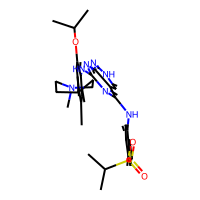
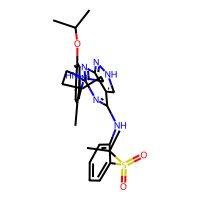
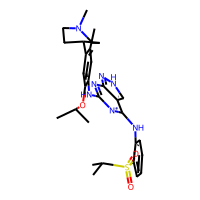
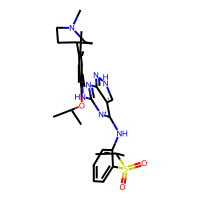
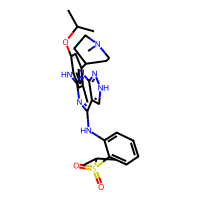
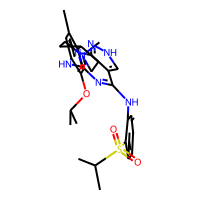
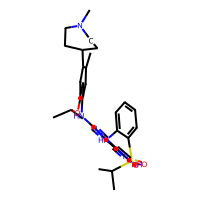
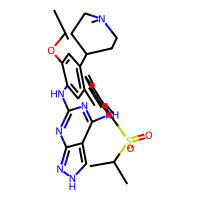
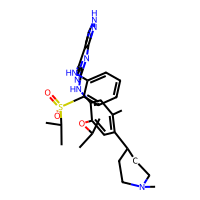

In [30]:
dockedposes

#### **Observation** We can see the list of poses, with the lowest energy pose at the top of the list. This lowest energy pose should be closest to the real binding pose of the compound in the receptor. Lets look at it.

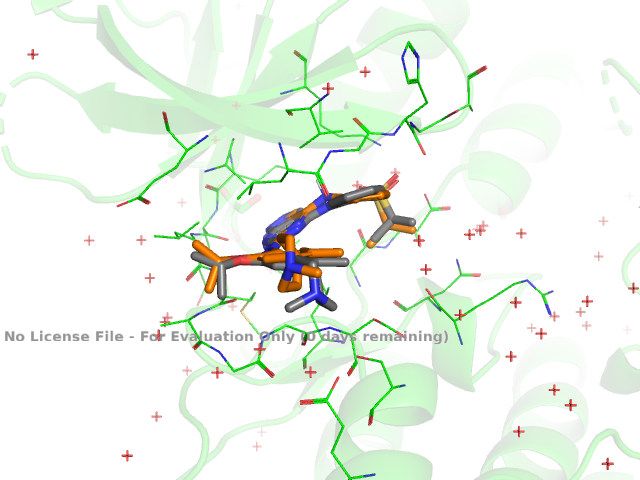

In [31]:
#Wipe the memory and load into the workspace
cmd.reinitialize()
cmd.load("4Z55-receptor.pdb")
cmd.load("4Z55-ligand.pdb")
cmd.load("4Z55-ligand-poses.sdf")


cmd.color("green","4Z55-receptor") #color the protein cyan
cmd.color("grey", "4Z55-ligand") #Color the original pose grey
cmd.color("orange", "4Z55-ligand-poses")

#We will cerate a selection sphere around the ligand and show the residues
cmd.select("pocketresidues", "byres (all within 5 of 4Z55-ligand)&polymer.protein")
cmd.show("line","pocketresidues")
cmd.set("ray_shadow",0)
cmd.set("cartoon_transparency", 0.8)
cmd.util.cnc()
cmd.zoom("pocketres") #zoom in on only the pocket
cmd.rotate("z","90")

camera = cmd.get_view() #save the camera viewpoint sometimes it can get reset so we will enforce the same

#display the best pose
camera = cmd.get_view()
cmd.png("pose.png")
Image(filename = "pose.png", unconfined=True)

#### **Observation**: We can see that the best smina docked pose is reasonably close to the original crystallographic pose. But lets look at all the poses and some higher energy poses.

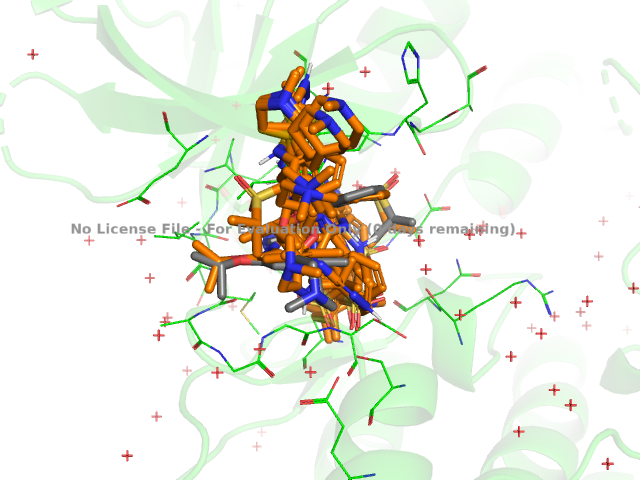

In [32]:
#show all the poses
cmd.set("all_states", 1)
cmd.set_view(camera)
cmd.png("pose.png")
Image(filename = "pose.png", unconfined=True)

In [33]:
#we can also get individual poses by splitting the poses into individual
cmd.set("all_states",0)
cmd.split_states("4Z55-ligand-poses")
cmd.get_names()

['4Z55-receptor',
 '4Z55-ligand',
 '4Z55-ligand-poses',
 '4Z55-ligand-poses_0001',
 '4Z55-ligand-poses_0002',
 '4Z55-ligand-poses_0003',
 '4Z55-ligand-poses_0004',
 '4Z55-ligand-poses_0005',
 '4Z55-ligand-poses_0006',
 '4Z55-ligand-poses_0007',
 '4Z55-ligand-poses_0008',
 '4Z55-ligand-poses_0009']

In [34]:
cmd.get_names()[-1]  #The last one in this list is the highest energy

'4Z55-ligand-poses_0009'

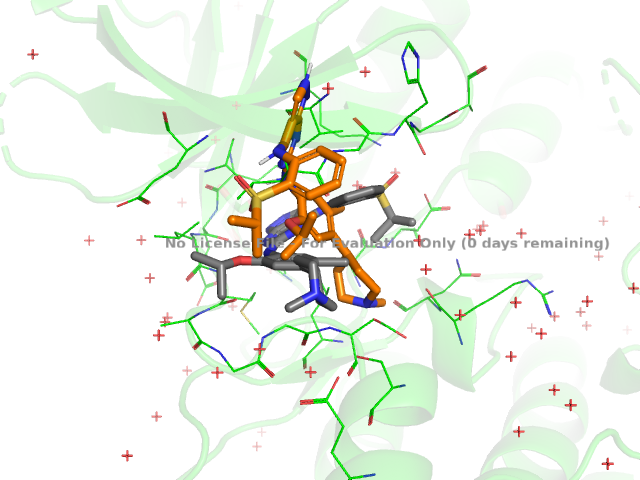

In [35]:
cmd.hide("everything","4Z55-ligand-poses*") #hide all the poses
worst = cmd.get_names()[-1]
cmd.show("stick",worst)  #Get the last pose, which should be the worst (highest energy)

cmd.set_view(camera)

cmd.png("pose.png")
Image(filename = "pose.png", unconfined=True)

#### **Observation** Now we can see that the worst energy ligand pose is very far from the original ligand pose

#### **Dock a library of ligands**

#### Now lets look at some random ligands, and some true positives and conduct a virtual screen

#### We will get some positives from ChEMBl that are known to bind to the receptor (but not necessarily this site - for this exercise we will assume that they do). For negatives, we can either pick true negatives from ChEMBL, but we can make the assumption that a random ligand will not posess the correct combination of interatomic interactions and conformational complementarity to bind very well to the receptor.

In [36]:
import requests

CHEMBL_API_URL = "https://www.ebi.ac.uk/chembl/api/data/activity.json"

def fetch_alk_binders(max_ic50_um = 15, chembl_api = CHEMBL_API_URL):
    ic50_molar = max_ic50_um * 1e-6
    pchembl = -np.log10(ic50_molar)
    params = {
        "target_chembl_id": "CHEMBL4247",
        "standard_type": "IC50",
        "pchembl_value__gte": pchembl,
        "limit": 1000
    }
    response = requests.get(chembl_api, params=params)
    if response.status_code == 200:
        data = response.json()
        if "activities" not in data:
            print("No data found.")
            return None
        compounds = [
            {
                "ChEMBLID": entry["molecule_chembl_id"],
                "Canonical SMILES": entry.get("canonical_smiles", "N/A"),
                "IC50 (uM)": float(entry["standard_value"]) / 1000 if entry.get("standard_units") == "nM" else entry.get("standard_value", "N/A"),
                "Standard Value (nM)": entry["standard_value"],
                "pChEMBL Value": entry.get("pchembl_value", "N/A"),
                "Target ChEMBL ID": entry["target_chembl_id"],
            }
            for entry in data["activities"]
        ]
        chembl_df = pd.DataFrame(compounds)
        return chembl_df

alk_binders_df = fetch_alk_binders()

#### ChEMBL simplifies activity values to a "pChembl" value - which is meant to represent the pIC50, or pEC50 etc. To simplify things, we will jus take rows that have pChembl > 8 as being "active"

In [37]:
for col in alk_binders_df.columns:
    print(col)

ChEMBLID
Canonical SMILES
IC50 (uM)
Standard Value (nM)
pChEMBL Value
Target ChEMBL ID


In [38]:
#Take only rows with pChembl > 8
alk_binders_df = alk_binders_df.rename(columns={"Canonical SMILES": "Smiles"})
alk_binders_df["pChEMBL Value"] = pd.to_numeric(alk_binders_df["pChEMBL Value"], errors='coerce')

actives=pd.DataFrame(alk_binders_df.loc[alk_binders_df['pChEMBL Value'] > 8]['Smiles'])
cognate=pd.DataFrame({"Smiles":["CC(C)Oc1cc(C2CCN(C)CC2)c(C)cc1Nc3nc(Nc4ccccc4[S](=O)(=O)C(C)C)c5c[nH]nc5n3"]}) #4LO

actives=pd.concat([actives,cognate]) # Make sure that we add the cognate ligand to the actives list


#Lets also compare the similarity with the cognate ligand
from rdkit import DataStructs

fpgen = AllChem.GetMorganGenerator()
query = Chem.MolFromSmiles('CC(C)Oc1cc(C2CCN(C)CC2)c(C)cc1Nc3nc(Nc4ccccc4[S](=O)(=O)C(C)C)c5c[nH]nc5n3')
queryfp = fpgen.GetFingerprint(query)

sim=[]
for x in actives.Smiles:
  target = Chem.MolFromSmiles(x)
  targetfp = fpgen.GetFingerprint(target)
  s=DataStructs.TanimotoSimilarity(targetfp,queryfp)
  sim.append(s)

actives = pd.DataFrame(actives)
actives["Active"]="True"
actives["Sim"]=sim
actives = actives.rename(columns = {'Smiles':'smiles'}) #adjust capitalization of name
actives=actives.sort_values("Sim",ascending=False)
actives=actives.drop_duplicates(subset='smiles', keep="first")
actives

,smiles,Active,Sim
0,CC(C)Oc1cc(C2CCN(C)CC2)c(C)cc1Nc3nc(Nc4ccccc4[...,True,1.000000
507,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...,True,0.552000
509,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...,True,0.524590
878,Cc1cc(Nc2ncc(Cl)c(Nc3cn(C)nc3S(=O)(=O)C(C)C)n2...,True,0.468750
894,Cc1cc(Nc2ncc(Cl)c(Nc3cn(C)nc3S(=O)(=O)C(C)C)n2...,True,0.389706
...,...,...,...
982,CCc1cc2c(cc1C1=CCN(C(=O)C3COCCN3)CC1)C(C)(C)c1...,True,0.077778
969,CCc1cc2c(cc1-c1cnn(CC(N)=O)c1)C(C)(C)c1[nH]c3c...,True,0.076923
229,Cn1cc(/C=C2\C(=O)NN=C2c2nccs2)c2c(OCc3c(F)cccc...,True,0.076923
968,CCc1cc2c(cc1-c1cnn(CC(=O)N(C)C)c1)C(C)(C)c1[nH...,True,0.075581


#### **Negatives** For negatives we can visit this site created by Dr. Irwin at UCSF - a tremendous resource for virtual screening. Chemical space is very large, and downloading all of these could take a serious amount of time. We will just take a small random sample
###https://zinc.docking.org/tranches/home/#

In [39]:
import requests

# Define file URLs and names
ligand_urls = {
    "sample_one.smi": "http://files.docking.org/2D/CD/CDAC.smi",
    "sample_two.smi": "http://files.docking.org/2D/EF/EFEA.smi",
    "sample_three.smi": "http://files.docking.org/2D/HJ/HJAB.smi"
}

# Download each file
for filename, url in ligand_urls.items():
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise error if request fails
        with open(filename, "wb") as file:
            file.write(response.content)
        print(f"✅ Successfully downloaded: {filename}")
    except requests.exceptions.RequestException as e:
        print(f"❌ Failed to download {filename}: {e}")



✅ Successfully downloaded: sample_one.smi
✅ Successfully downloaded: sample_two.smi
✅ Successfully downloaded: sample_three.smi


In [40]:
#OK lets load all of them into a single dataframe
frames = [pd.read_csv('sample_one.smi', sep=" "),
          pd.read_csv('sample_two.smi', sep=" "),
          pd.read_csv('sample_three.smi', sep=" ")]
randoms = pd.concat(frames,ignore_index=True)

In [41]:
randoms

,smiles,zinc_id
0,O=C(NCCN1CCC(O)CC1)OCc1ccccc1,306320515
1,CC(C)(C)OC(=O)N1CCC2(CC1)C[C@@H](N)CCO2,91303585
2,O=C(Cc1ncon1)Nc1ccc(F)c(F)c1F,93298
3,Cc1cc(F)c(B(O)OC(C)(C)C(C)(C)O)cc1C,200317185
4,CCOC(=O)[C@]1(C)Oc2cc(Cl)ccc2NC1=O,26340455
...,...,...
91268,Cc1nc([C@H]2CCN(CC3CCCCC3)C2)nc(C)c1CC(=O)Nc1c...,257287581
91269,CC[C@@H]1CSC2=N[C@@H](c3ccccn3)[C@H](c3cccn3-c...,260780925
91270,CC[C@H](C)OC(=O)CN1C(=O)S/C(=C/c2ccc(-c3ccc(F)...,408600907
91271,Cc1ccc(C)c(NC(=O)CSc2nnc(COc3ccc4c(c3)CCCC4)o2)c1,409008213


In [42]:
randoms.head()

,smiles,zinc_id
0,O=C(NCCN1CCC(O)CC1)OCc1ccccc1,306320515
1,CC(C)(C)OC(=O)N1CCC2(CC1)C[C@@H](N)CCO2,91303585
2,O=C(Cc1ncon1)Nc1ccc(F)c(F)c1F,93298
3,Cc1cc(F)c(B(O)OC(C)(C)C(C)(C)O)cc1C,200317185
4,CCOC(=O)[C@]1(C)Oc2cc(Cl)ccc2NC1=O,26340455


In [43]:
#Calculate the similarity of the random mols to 4LO
randoms=pd.DataFrame(randoms['smiles'])
randoms=randoms.sample(300)

sim=[]
for x in randoms.smiles:
  target = Chem.MolFromSmiles(x)
  targetfp = fpgen.GetFingerprint(target)
  s=DataStructs.TanimotoSimilarity(targetfp,queryfp)
  sim.append(s)

randoms["Active"]="False"
randoms["Sim"]=sim
randoms=randoms.sort_values("Sim", ascending=False)
randoms.head()

,smiles,Active,Sim
63531,Cc1cc(C)cc(Nc2nc(NC[C@@H]3CCCO3)nc3c2cnn3-c2cc...,False,0.175676
25355,Cc1ccc(S(=O)(=O)N2CCCCCC2)cc1C(=O)Nc1ccccc1C(C)C,False,0.165468
73030,CCn1c2ccccc2c2cc(NC(=O)c3ccccc3S(=O)(=O)CC)ccc21,False,0.157143
26827,COC(=O)c1cc2ccccc2cc1NC(=O)c1cc(C(C)C)nc2c1c(C...,False,0.151724
60173,COc1cc(C(F)(F)F)ccc1C(=O)Nc1ccccc1C(=O)N1CCCC[...,False,0.148649


#### **Observation:** We can see that the random molecules are  very dissimilar from the cognate ligand.

In [44]:
#For our positives, we will take the 10 most similar rows to the cognate ligand. The assumption here
#is that similar ligands could potentially bind to the same site
activesample=actives.sort_values("Sim", ascending=False)[0:3]
print(activesample)

                                                smiles Active      Sim
0    CC(C)Oc1cc(C2CCN(C)CC2)c(C)cc1Nc3nc(Nc4ccccc4[...   True  1.00000
507  Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...   True  0.55200
509  Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...   True  0.52459


In [45]:
## OK - we have negatives (random molecules) as sdf, and then some positives as smiles. Lets make a uniform dataframe as all smiles
## We will make a dataframe of 3 positives, and 7 randoms
import random
import numpy as np
vsmols = pd.concat([activesample,randoms.sample(7)])
#Ok now we have a dataframe with some actives and some negatives. Last thing to do is to create a unique ID
number=np.arange(0,len(vsmols)).astype('str')
vsmols["ID"]=np.char.add('Molecule_',number)

In [46]:
vsmols.head(10)

,smiles,Active,Sim,ID
0,CC(C)Oc1cc(C2CCN(C)CC2)c(C)cc1Nc3nc(Nc4ccccc4[...,True,1.000000,Molecule_0
507,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...,True,0.552000,Molecule_1
509,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...,True,0.524590,Molecule_2
45961,C[C@H](NC(=O)CSc1nncn1-c1ccccc1F)c1cccc2ccccc12,False,0.100629,Molecule_3
45255,CCc1ccccc1NC(=O)c1cccc(S(=O)(=O)Nc2cccc(Cl)c2)c1,False,0.100671,Molecule_4
7216,CC(C)(C)c1cnc(N2CCN(c3ccc(O)nc3)CC2)c(C#N)c1,False,0.077465,Molecule_5
55458,O=C(c1cccc(Cl)c1)N1CCC(F)(F)[C@]2(CCN(c3cccc(F...,False,0.070968,Molecule_6
70763,CCn1c(COc2cccc(C)c2C)nnc1SCC(=O)Nc1ccc(C)cc1,False,0.110390,Molecule_7
91131,CCc1ccc(-c2csc(NC(=O)[C@@H](C)Sc3nnc(C4CC4)o3)...,False,0.096154,Molecule_8
21804,Cc1nc(Oc2ccccc2F)nc(C)c1NC(=O)COc1ccc(Cl)cc1,False,0.125874,Molecule_9


In [47]:
#Ok now we need to convert all these SMILES into 3d structures

#write a conversion function to convert SMILES to a 3D structure
def Convert3D(molsmile):
  mol = Chem.MolFromSmiles(molsmile)
  mol = Chem.AddHs(mol, addCoords=True)
  AllChem.EmbedMolecule(mol)
  AllChem.MMFFOptimizeMolecule(mol)
  return mol

In [48]:
minim=[]
for x in vsmols.smiles:
  minim.append(Convert3D(x))

In [49]:
#add the column of minimized structures to our dataframe
vsmols["minim"]=minim

In [50]:
vsmols.head(10)

,smiles,Active,Sim,ID,minim
0,CC(C)Oc1cc(C2CCN(C)CC2)c(C)cc1Nc3nc(Nc4ccccc4[...,True,1.000000,Molecule_0,<rdkit.Chem.rdchem.Mol object at 0x0000023315F...
507,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...,True,0.552000,Molecule_1,<rdkit.Chem.rdchem.Mol object at 0x0000023315F...
509,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...,True,0.524590,Molecule_2,<rdkit.Chem.rdchem.Mol object at 0x0000023315F...
45961,C[C@H](NC(=O)CSc1nncn1-c1ccccc1F)c1cccc2ccccc12,False,0.100629,Molecule_3,<rdkit.Chem.rdchem.Mol object at 0x0000023315F...
45255,CCc1ccccc1NC(=O)c1cccc(S(=O)(=O)Nc2cccc(Cl)c2)c1,False,0.100671,Molecule_4,<rdkit.Chem.rdchem.Mol object at 0x0000023315F...
7216,CC(C)(C)c1cnc(N2CCN(c3ccc(O)nc3)CC2)c(C#N)c1,False,0.077465,Molecule_5,<rdkit.Chem.rdchem.Mol object at 0x0000023315F...
55458,O=C(c1cccc(Cl)c1)N1CCC(F)(F)[C@]2(CCN(c3cccc(F...,False,0.070968,Molecule_6,<rdkit.Chem.rdchem.Mol object at 0x0000023315F...
70763,CCn1c(COc2cccc(C)c2C)nnc1SCC(=O)Nc1ccc(C)cc1,False,0.110390,Molecule_7,<rdkit.Chem.rdchem.Mol object at 0x0000023315F...
91131,CCc1ccc(-c2csc(NC(=O)[C@@H](C)Sc3nnc(C4CC4)o3)...,False,0.096154,Molecule_8,<rdkit.Chem.rdchem.Mol object at 0x0000023315F...
21804,Cc1nc(Oc2ccccc2F)nc(C)c1NC(=O)COc1ccc(Cl)cc1,False,0.125874,Molecule_9,<rdkit.Chem.rdchem.Mol object at 0x0000023315F...


In [51]:
#Write the minimized 3D structures to a file for Smina to dock

PandasTools.WriteSDF(vsmols, out="dockingligands.sdf",
                     molColName='minim',
                     idName='ID',
                     properties=None,
                     allNumeric=False,
                     forceV3000=False)

In [58]:
#Allright now lets dock the sdf to the receptor, with maximum speed (exhaustiveness = 1), and accept only 1 pose per ligand (num_modes = 1)
#Docking speed usually depends on the number of rotatable bonds, with more taking longer to sample and "fit" to the protein
#Colab pro may have access to faster CPUs
!wsl ./smina.static -r  4Z55-receptor.pdb -l dockingligands.sdf --autobox_ligand 4Z55-ligand.pdb -o output.sdf --exhaustiveness 1 --num_modes 1 -q


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 11.9095

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 16.3233

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 10.3503

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 4.09458

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 3.58637

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|---

*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


In [59]:
#now load the results
vsresults = PandasTools.LoadSDF("output.sdf")

merged=vsmols.merge(vsresults, left_on="ID",right_on="ID")
merged=merged[['ID','Active','Sim','minimizedAffinity']] #We can clean up a few of the columns
merged=merged.sort_values('minimizedAffinity', ascending=True)
merged

[22:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol as 3D.
[22:28:09] Warning: molecule is tagged as 2D, but at least one Z coordinate is not zero. Marking the mol

,ID,Active,Sim,minimizedAffinity
0,Molecule_0,True,1.000000,-10.33072
5,Molecule_5,False,0.077465,-7.28969
7,Molecule_7,False,0.110390,-7.86899
9,Molecule_9,False,0.125874,-8.00171
8,Molecule_8,False,0.096154,-8.08743
1,Molecule_1,True,0.552000,-8.14979
6,Molecule_6,False,0.070968,-8.62694
3,Molecule_3,False,0.100629,-9.10356
4,Molecule_4,False,0.100671,-9.24877
2,Molecule_2,True,0.524590,-9.94205


In [60]:
#Something looks wrong here - have to make sure that the score column (MinimizedAffinity is treated as a number)
merged['minimizedAffinity']=merged['minimizedAffinity'].astype('float64')
merged=merged.sort_values('minimizedAffinity', ascending=True)
merged

,ID,Active,Sim,minimizedAffinity
0,Molecule_0,True,1.000000,-10.33072
2,Molecule_2,True,0.524590,-9.94205
4,Molecule_4,False,0.100671,-9.24877
3,Molecule_3,False,0.100629,-9.10356
6,Molecule_6,False,0.070968,-8.62694
1,Molecule_1,True,0.552000,-8.14979
8,Molecule_8,False,0.096154,-8.08743
9,Molecule_9,False,0.125874,-8.00171
7,Molecule_7,False,0.110390,-7.86899
5,Molecule_5,False,0.077465,-7.28969


#### **Observation:** We can see that 2/3 of the true positives were pushed to the top of the list (meaning Smina thought they were good binders). Lets calculate a ROC plot to measure performance.

C:\Users\Stephen\AppData\Local\Temp\ipykernel_344\102533532.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged.replace({"False": 0, "True": 1}, inplace=True)


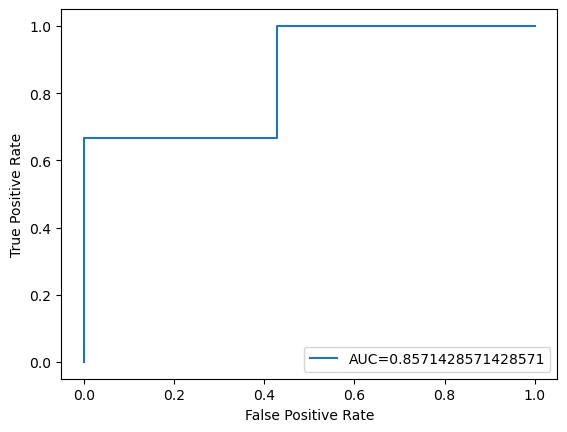

In [61]:
from sklearn import metrics
import matplotlib.pyplot as plt

#convert Actie = True False to 1 or 0
merged.replace({"False": 0, "True": 1}, inplace=True)


#define metrics
fpr, tpr, _ = metrics.roc_curve(merged['Active'],  -merged['minimizedAffinity']) #Use the negative of the score here to rank more negative scores better
auc = metrics.roc_auc_score(merged['Active'],  -merged['minimizedAffinity']) #Also invert the score here too

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

####**Observation** Intuitively this ROC plot makes sense. We can see the docking experiment enriched true actives somewhat toward the top of the list, meaning that the true positives were ranked highly most of the time.

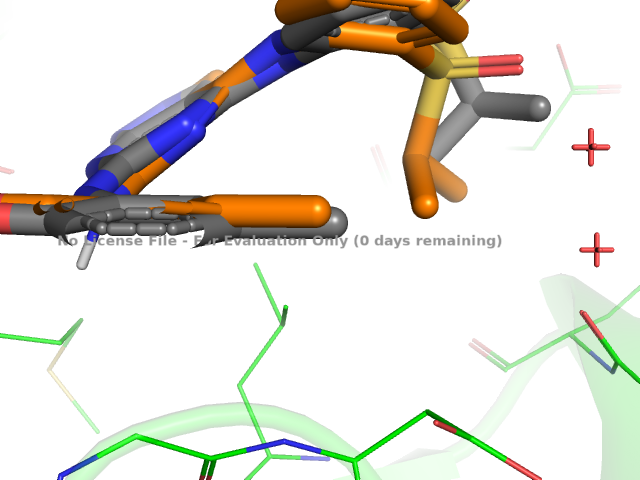

In [62]:
#Wipe the memory and load into the workspace
cmd.reinitialize()
cmd.load("4Z55-receptor.pdb")
cmd.load("4Z55-ligand.pdb")
cmd.load("virtualscreen.sdf")


cmd.color("green","4Z55-receptor") #color the protein cyan
cmd.color("grey", "4Z55-ligand") #Color the original pose grey
cmd.color("orange", "virtualscreen")

#We will cerate a selection sphere around the ligand and show the residues
cmd.select("pocketresidues", "byres (all within 5 of 4Z55-ligand)&polymer.protein")
cmd.show("line","pocketresidues")
cmd.set("ray_shadow",0)
cmd.set("cartoon_transparency", 0.8)
cmd.util.cnc()
cmd.zoom("pocketres") #zoom in on only the pocket
cmd.rotate("z","90")
camera = cmd.get_view() #save the camera viewpoint sometimes it can get reset so we will enforce the same

#ok lets split the states and show the first docked ligand
cmd.split_states("virtualscreen")
cmd.remove("virtualscreen")
cmd.hide("stick","Molecule_*")
cmd.show("stick","Molecule_0")

cmd.png("pose.png")
Image(filename = "pose.png", unconfined=True)

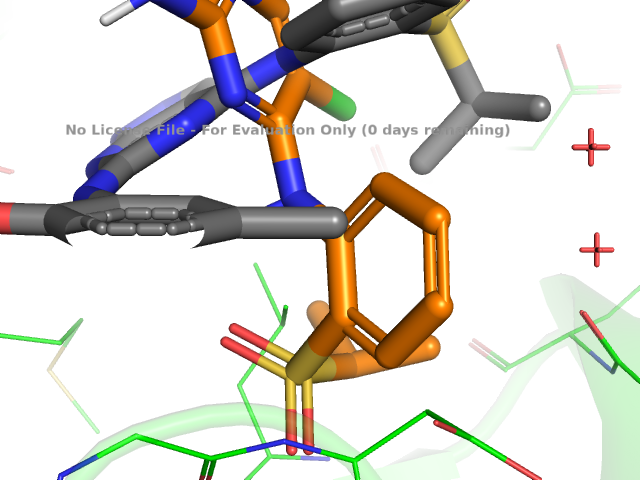

In [63]:
cmd.hide("stick","Molecule_*")
cmd.show("stick","Molecule_1")

cmd.png("pose.png")
Image(filename = "pose.png", unconfined=True)

#### **Observation** We can see that while some of the similar aromatic rings got placed near the original pose (grey) there are quite a few differences. Analyze the rest of the dataset!

In [70]:
import random
from rdkit import Chem
from rdkit.Chem import SDWriter, FilterCatalog
from rdkit.Chem.FilterCatalog import FilterCatalogParams
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')  # Suppress all RDKit warnings

# Load the SDF file
sdf_file = "Week6-VirtualLibrary.sdf"
suppl = Chem.SDMolSupplier(sdf_file)

# Convert to list and filter valid molecules
mols = [mol for mol in suppl if mol is not None]

# Load PAINS filter from RDKit
pains_catalog = FilterCatalog.FilterCatalogParams()
pains_catalog.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_A)
pains_catalog.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_B)
pains_catalog.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS_C)
pains_filter = FilterCatalog.FilterCatalog(pains_catalog)

# Filter molecules: Remove PAINS compounds
filtered_mols = [mol for mol in mols if not pains_filter.HasMatch(mol)]

# Select 10 random non-PAINS molecules
random_subset = random.sample(filtered_mols, min(200, len(filtered_mols)))

# Add hydrogens to each selected molecule
mols_with_h = [Chem.AddHs(mol) for mol in random_subset]

# Write to new SDF file
output_sdf = "filtered_no_PAINS.sdf"
writer = SDWriter(output_sdf)

for mol in mols_with_h:
    writer.write(mol)

writer.close()

print(f"✅ Successfully created {output_sdf} with 200 non-PAINS ligands (Hydrogens Added)")


✅ Successfully created filtered_no_PAINS.sdf with 200 non-PAINS ligands (Hydrogens Added)


In [71]:
!wsl ./smina.static -r  4Z55-receptor.pdb -l filtered_no_PAINS.sdf --autobox_ligand 4Z55-ligand.pdb -o full_data.sdf --exhaustiveness 1 --num_modes 1 -q


0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 1.06848

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 1.34682

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 3.95764

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 2.86541

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************
Refine time 1.66891

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|---

*** Open Babel Warning  in Init
  Unable to open data file 'space-groups.txt'
*** Open Babel Warning  in Init
  Cannot initialize database 'space-groups.txt' which may cause further errors.


In [88]:
subset_results= PandasTools.LoadSDF("full_data.sdf")
filter_no_pains = PandasTools.LoadSDF("filtered_no_PAINS.sdf")

merged=filter_no_pains.merge(subset_results, left_on="ID",right_on="ID")
merged=merged[['ID','minimizedAffinity']] #We can clean up a few of the columns
merged['minimizedAffinity']=merged['minimizedAffinity'].astype('float64')
merged=merged.sort_values('minimizedAffinity', ascending=True)
merged

,ID,minimizedAffinity
161,ZINC000003328706,-9.91545
66,ZINC000016248871,-9.29532
85,ZINC000000788703,-9.17463
170,ZINC000019961074,-9.06716
95,ZINC000012823896,-8.97571
...,...,...
57,ZINC000008777097,-5.83903
98,ZINC000079387582,-5.69655
77,ZINC000073373064,-5.63793
167,ZINC000253387604,-5.55237
